## Install Requirements
******Remember to restart the kernel after installing

In [2]:
%pip install --upgrade pip
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Ignoring tensorflow: markers 'sys_platform == "linux"' don't match your environment
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Helper Functions

In [3]:
def calc_median(frames):
    median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
    return median_frame

def doMovingAverageBGS(image, prev_frames):
    median_img = calc_median(prev_frames)
    image = cv2.absdiff(image, median_img)
    return image

# Binarization of images and thresholding


In [1]:
def binarize(img, threshold=0.5):
    img[img > threshold] = 1
    img[img <= threshold] = 0
    return img

In [5]:
def extractImages(pathIn, pathOut, leakRange, nonleakRange, currCountLeak, currCountNonLeak):

  '''
  Input:
    String: pathIn should be the path of the video 
    String: pathOut should be the path of the folder where data is being stored for testing or training
    Tuple: range of leak frames from video
    Tuple: range of nonleak frames from video

  Output:
    creates two subfolders in pathOut called Leaks and Nonleaks
      Leaks folder contains the frames where there are leaks
      Nonleaks folder contains the frames where there are noleaks
  '''

  leakPath = os.path.join(pathOut, "Leak")
  nonleakPath = os.path.join(pathOut, "Nonleaks")
  
  os.makedirs(leakPath, exist_ok=True)
  os.makedirs(nonleakPath, exist_ok=True)

  def helper(pathIn, pathOut, range, isLeak, currCountLeak, currCountNonLeak):
    '''
    Might need to clean this up, but this was extracted from the original extractImages from the previous implementation
    
    '''
    #setting up moving average list
    prev_imgs = []
    prev_limit = 210 #210 in paper

    start = range[0] * 1000 # converting seconds to milliseconds
    end = range[1] * 1000
    cap = cv2.VideoCapture(pathIn)
    cap.set(cv2.CAP_PROP_POS_MSEC, start)
    success = True

    if cap.isOpened():
      while success and start < end:  
          success, image = cap.read()
          image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

          start = cap.get(cv2.CAP_PROP_POS_MSEC)
          if success:

            prev_imgs.append(image)
            if len(prev_imgs) > prev_limit:
                prev_imgs.pop(0)
          
            processed_img = doMovingAverageBGS(image, prev_imgs) #to generalize might need to make this function as a parameter
            
            if isLeak:
                cv2.imwrite(os.path.join(pathOut, "leak.frame%d.jpg" % currCountLeak), processed_img)     # save frame as JPEG file
                currCountLeak += 1
            else:
                cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.jpg" % currCountNonLeak), processed_img)
                currCountNonLeak += 1
          else:
            break
      cap.release()
    cv2.destroyAllWindows()
    if isLeak:
       return currCountLeak
    else:
       return currCountNonLeak
  # call helper for both nonLeak and leak and get updated counts
  updated_currCountNonLeak = helper(pathIn, nonleakPath, nonleakRange, isLeak=False, currCountLeak=currCountLeak, currCountNonLeak=currCountNonLeak)
  updated_currCountLeak = helper(pathIn, leakPath, leakRange, isLeak=True,currCountLeak=currCountLeak, currCountNonLeak=currCountNonLeak)
  
  return updated_currCountNonLeak, updated_currCountLeak

## Setting Up Directories
### Make sure frame_data_dir is set to a different name

In [6]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data_movingAvg_Adam_Ubuntu')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

## Setting Up Ranges for Each Video In GasVid (Excluding 18.6m and 8.8m)

In [7]:
raw_data = np.loadtxt(os.path.join(dir_path, 'GasVid_Ranges_Seconds.csv'), skiprows=1, delimiter=',', dtype=int)

ranges = list(zip(raw_data[:, 0], raw_data[:, 1:3], raw_data[:, 3:5])) #need to upload new ranges
ranges = {ranges[i][0] : (ranges[i][1], ranges[i][2]) for i in range(len(ranges))}
len(ranges)

25

In [8]:
def read_frames_from_dir(dir_path, output_path, max_vids=None):
    cur_count = 1
    currNonLeakCount = 0
    currLeakCount = 0
    
    for file in os.listdir(dir_path):
        if max_vids and cur_count > max_vids:
            break
        vid_path = os.path.join(dir_path, file)
        vid_id = int(os.path.basename(vid_path)[4:8])
        if vid_id not in ranges.keys():
            continue

        nonleak_start = ranges[vid_id][0][0]
        nonleak_end = ranges[vid_id][0][1]
        leak_start = ranges[vid_id][1][0]
        leak_end = ranges[vid_id][1][1]

        currNonLeakCount, currLeakCount = extractImages(vid_path, output_path, (leak_start, leak_end), (nonleak_start, nonleak_end), currLeakCount, currNonLeakCount)
        print("Video", vid_id)
        print("Current NonLeak Count", currNonLeakCount)
        print("Current Leak Count", currLeakCount)

        print('Done with', cur_count, "video(s)")
        cur_count += 1
    return currNonLeakCount, currLeakCount

## Reading Frames from Data Directory and Setting Them in Frame Data Directory

In [8]:
image_dim = (240, 320)
vid_count = 15 #max =>15
test_count = 10 #max =>10

total_train_NonLeak, total_train_Leak = read_frames_from_dir(train_data_dir, frame_train_data_dir, vid_count)
print("Done with Training Data")
total_test_NonLeak, total_test_Leak = read_frames_from_dir(test_data_dir, frame_test_data_dir, test_count)
print("Done with Testing Data")
#weird bug in which it if vid_count is 1 goes on to the next one
#might need to cut in amount of samples but we will see

KeyboardInterrupt: 

In [9]:
total_train_NonLeak, total_train_Leak = 35779, 277114
total_test_NonLeak, total_test_Leak = 23857, 184811

## Setting Up Generators for Training, Validation, and Testing

### I split the training generator into a Leak and Nonleak generator where the NonLeak generated has random image augmentations performed on it.
### Both generators are then combined in the next following cell to construct a training generator with equal amounts of Leak and NonLeak images.

In [113]:
from keras.preprocessing.image import ImageDataGenerator

val_split = 0.2
batch_size = 64
# target_size = (240, 320)
target_size = (224, 224)


# frame_data_dir = os.path.join(dir_path, 'frame_data_movingAvg')
# frame_train_data_dir = os.path.join(frame_data_dir, 'train')

# Augmentations added in this ImageDataGenerator
# Augmentation only for non-leak images
nonleak_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    validation_split=val_split,
)

nonleak_train_generator = nonleak_datagen.flow_from_directory(
    directory=os.path.join(frame_train_data_dir, "NonleaksAugmented"),
    class_mode="binary",
    subset="training",
    batch_size=batch_size//2,
    # color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks"]
)

# No augmentation for leak images
leak_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=val_split,
)

leak_train_generator = leak_datagen.flow_from_directory(
    directory=os.path.join(frame_train_data_dir, "LeaksAugmented"),
    class_mode="binary",
    subset="training",
    batch_size=batch_size//2,
    # color_mode="grayscale",
    target_size=target_size,
    classes=["Leak"]
)

train_datagen = ImageDataGenerator(
    # featurewise_center=True, #cant do this as need entire dataset to do it | need to figure out a way in doing this
    # featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=val_split,
)


train_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="training",
    batch_size=batch_size,
    # color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)

val_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="validation",
    batch_size=batch_size,
    # color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)


test_datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rescale=1. / 255,
)


test_generator = test_datagen.flow_from_directory(
    directory=frame_test_data_dir, 
    class_mode='binary', 
    batch_size=batch_size,
    # color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)


Found 28624 images belonging to 1 classes.
Found 221692 images belonging to 1 classes.
Found 250316 images belonging to 2 classes.
Found 62577 images belonging to 2 classes.
Found 208668 images belonging to 2 classes.


In [80]:
# Combine the leak and non leak data generators
# Get equal amounts of leak and non leak data

def combined_generator(leak_gen, nonleak_gen, batch_size):
    while True:
        # Get half the batch from Leak generator
        leak_images, leak_labels = next(leak_gen)
        
        # Get half batch from Nonleak generator
        nonleak_images, nonleak_labels = next(nonleak_gen)
        
        leak_labels = leak_labels[:, np.newaxis]      # Reshape (16,) to (16, 1)
        # Convert from zero to 1
        leak_labels = np.where(leak_labels == 0, 1, leak_labels)

        nonleak_labels = nonleak_labels[:, np.newaxis] # Reshape (16,) to (16, 1)
        # Combine
        combined_images = np.vstack((leak_images, nonleak_images))
        combined_labels = np.vstack((leak_labels, nonleak_labels))

        # Shuffle
        idx = np.arange(combined_images.shape[0])
        np.random.shuffle(idx)
        
        combined_images = combined_images[idx]
        combined_labels = combined_labels[idx]

        yield combined_images, combined_labels


combined_gen = combined_generator(leak_train_generator, nonleak_train_generator, batch_size=batch_size)


In [81]:
total_train_frames = total_train_NonLeak + total_train_Leak
total_train_frames

312893

In [82]:
combined_generator

num_leak_images = leak_train_generator.samples
num_nonleak_images = nonleak_train_generator.samples

print(f"Number of Leak images: {num_leak_images}")
print(f"Number of Nonleak images: {num_nonleak_images}")

Number of Leak images: 221692
Number of Nonleak images: 28624


In [83]:
total_batches = leak_train_generator.__len__() + nonleak_train_generator.__len__() + val_generator.__len__()
total_batches

17601

## Class Weights

In [84]:

# Shouldn't need a weighted average now that we are pulling an equal number of leaks and nonleaks


nonleaks = total_train_NonLeak
leaks = total_train_Leak
total = nonleaks + leaks

weight_nonleak = (1 / nonleaks) * (total / 2.0)
weight_leak = (1 / leaks) * (total / 2.0)


class_weight = {leak_train_generator.class_indices["Nonleaks"]: weight_nonleak, nonleak_train_generator.class_indices["Nonleaks"]: weight_leak}
class_weight

KeyError: 'Nonleaks'

In [33]:
leak_samples = leak_train_generator.samples
print(f"Leak samples: {leak_samples}")
nonleak_samples = nonleak_train_generator.samples
print(f"Nonleak samples: {nonleak_samples}")
validation_samples = val_generator.samples

Leak samples: 221692
Nonleak samples: 28624


## Model

In [72]:
from keras import layers 
from keras import models 

model = models.Sequential() 

# Conv Pool 1
model.add(layers.Conv2D(4, (3, 3), input_shape=(240, 320, 1)))
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Conv Pool 2
model.add(layers.Conv2D(8, (3, 3)))
model.add(layers.ReLU())
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Conv Pool 3
model.add(layers.Conv2D(16, (3, 3)))
model.add(layers.ReLU())
model.add(layers.Dropout(0.4))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Conv Pool4
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())

model.add(layers.Dense(2400, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 238, 318, 4)       40        
                                                                 
 re_lu_4 (ReLU)              (None, 238, 318, 4)       0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 119, 159, 4)       0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 119, 159, 4)       16        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 117, 157, 8)       296       
                                                                 
 re_lu_5 (ReLU)              (None, 117, 157, 8)      

# Transfer Learning

In [85]:
# from keras.applications import VGG16
# from keras import layers, models, optimizers

# # Load the VGG16 model without its top (fully connected) layers
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 320, 3))

# # Freeze the layers of the base model (so their weights won't be updated during training)
# for layer in base_model.layers:
#     layer.trainable = False

# # Create a new model on top
# model = models.Sequential()
# model.add(base_model)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))  # binary classification


58889256/58889256 [==============================] - 2s 0us/step


In [114]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# Load the MobileNet model excluding the top fully connected layers
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification




## Data Visualization (Confusion Matrix and ROC Curves)

In [115]:
#code from https://neptune.ai/blog/keras-metrics
#to use to plot confusion matrix and roc curve after each epock
#uncomment when you need it 

import os

from keras.callbacks import Callback
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, num_batches, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.num_batches = num_batches

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_true = []
        y_pred = []
        batch_num = 0
        for data, true_label in self.validation_data:
            batch_pred = self.model.predict(data, verbose=0)
            y_pred.append(batch_pred)
            y_true.append(true_label)

            if batch_num >= self.num_batches:
                break
            batch_num += 1

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        threshold = 0.5
        y_pred = (y_pred > threshold).astype(int)
        

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        cm = confusion_matrix(y_true, y_pred)
        # cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax, name=f"Confusion Matrix of Validation Data at Epoch {epoch}")
        cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
        ax.set_title(f"Confusion Matrix of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

        # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name=f"ROC Curve of Validation Data at Epoch {epoch}")
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
        ax.set_title(f"ROC Curve of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=val_generator,
                      num_batches=len(val_generator),
                      image_dir='performance_vizualizations')

## Training Model

In [116]:
from keras import optimizers 
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle

def F1Score(y_true, y_pred):
    threshold = 0.5
    y_pred = tf.where(y_pred >= threshold, 1.0, 0.0)

    prec = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    
    prec.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    
    prec_res = prec.result()
    rec_res = recall.result()

    return tf.where(tf.math.add(prec_res, rec_res) > 0, 
                    2 * (prec_res * rec_res) / (prec_res + rec_res), 
                    0.0)


# model.compile(loss='binary_crossentropy', optimizer=optimizers.legacy.Adam(learning_rate=1e-4), metrics=[F1Score, "acc"], run_eagerly=True)
# Unfreeze some layers in the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile with a low learning rate
# model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=[F1Score, "acc"], run_eagerly=True)
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=1e-4), loss='binary_crossentropy',  metrics=[F1Score, "acc"], run_eagerly=True)




In [117]:
from keras.callbacks import Callback
import pickle

class SaveHistory(Callback):
    def __init__(self, filepath):
        super(SaveHistory, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filepath, 'wb') as file:
            pickle.dump(self.model.history.history, file)

In [118]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
# Create an instance of the custom callback
save_history_callback = SaveHistory('training_history.pkl')

num_epochs = 4

history = model.fit(
    # x = combined_gen,
    x = train_generator,
    # steps_per_epoch = (leak_train_generator.samples + nonleak_train_generator.samples) // batch_size,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = num_epochs,
    # class_weight = class_weight, # Removed since we are performing Data augmentation on Non leak data
    callbacks=[performance_cbk, early_stop, save_history_callback] #uncomment once you want to use it
)

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/4
 308/3911 [=>............................] - ETA: 2:12:39 - loss: 0.1411 - F1Score: 0.9711 - acc: 0.9497

In [66]:
# Load the trained model instead of retraining:
from keras.models import load_model


loaded_model = load_model("Adam\'s_Model_10_Epoch.h5")

# loaded_model.compile(loss='binary_crossentropy', optimizer=optimizers.legacy.Adam(learning_rate=1e-4), metrics=[F1Score, "acc"], run_eagerly=True)


In [67]:
score = loaded_model.evaluate(val_generator)

1956/1956 [==============================] - 68s 34ms/step - loss: 0.7742 - F1Score: 0.9387 - acc: 0.1143


## Model Metrics Over Epochs

In [36]:
import matplotlib.pyplot as plt 

f1 = history.history['F1Score'] 
val_f1 = history.history['val_F1Score'] 

loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

acc = history.history["acc"]
val_acc = history.history["val_acc"]

epochs = range(1, len(f1) + 1) 

plt.plot(epochs, f1, 'bo', label='Training F1 Score') 
plt.plot(epochs, val_f1, 'b', label='Validation F1 Score') 
plt.title('Training and Validation F1 Score') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training loss and validation loss') 
plt.legend() 

plt.plot(epochs, acc, 'bo', label='Training Accuracy') 
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') 
plt.title('Training and Validation Accuracy') 
plt.legend() 

plt.figure() 

plt.show() 

TypeError: 'History' object is not subscriptable

## Testing

In [68]:
test_mean, test_std = generate_stats(gens=[test_generator], centerFirst=True)
test_mean, test_std

Calculating mean...
Length of Generator 6521
Done with one generator!
Total Batches 6521
Reset Generator
Done!
Calculating std from centered data...
Length of Generator 6521
Done with one generator!
Total Batches 6521
Reset Generator
Done!


(array([0.00596231]), array([0.01576744]))

In [69]:
test_mean = test_mean[0]
test_std = test_std[0]

In [70]:
#source: https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator

# Create lists for storing the predictions and labels
predictions = []
true_labels = []

threshold = 0.5
# Get the total number of labels in generator 
# (i.e. the length of the dataset where the generator generates batches from)
length_test = len(test_generator.labels)

# Loop over the generator
for data, label in get_with_featurewise_center_std_norm(test_generator, test_mean, test_std):
    # Make predictions on data using the model. Store the results.
    # preds = model.predict(data, verbose=0)
    preds = loaded_model.predict(data, verbose=0)
    processed_preds = (preds >= threshold).flatten().astype(int)
    predictions.extend(processed_preds)
    # Store corresponding labels
    true_labels.extend(label.astype(int))
    
    # We have to break out from the generator when we've processed 
    # the entire once (otherwise we would end up with duplicates). 
    if len(predictions) == length_test:
        break

In [71]:
len(predictions), len(true_labels)

(208668, 208668)

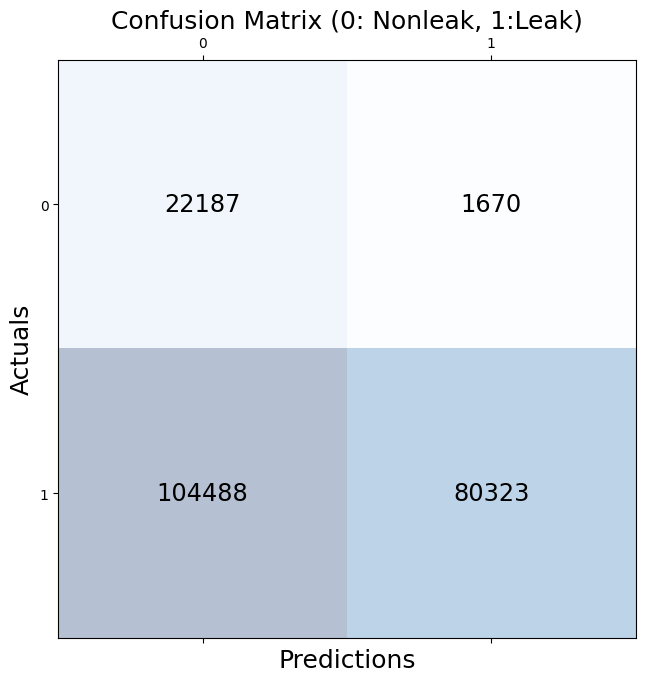

In [72]:
from sklearn.metrics import confusion_matrix

#source: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

conf_matrix = confusion_matrix(y_true=true_labels, y_pred=predictions)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix (0: Nonleak, 1:Leak)', fontsize=18)
plt.show()

In [73]:
# Extract the true positive, true negative, false positive, and false negative values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
 
# Print the true positive, true negative, false positive, and false negative values
print("True Positive (TP): ", tp)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("False Negative (FN): ", fn)
 
# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
 
# Calculate precision
precision = tp / (tp + fp)
 
# Calculate recall
recall = tp / (tp + fn)
 
# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)
 
# Print the formulas for accuracy, precision, recall, and F1-score
print("\n\nFormulas:")
print("Accuracy: (TP + TN) / (TP + TN + FP + FN)")
print("Precision: TP / (TP + FP)")
print("Recall: TP / (TP + FN)")
print("F1-score: 2 * (Precision * Recall) / (Precision + Recall)")
 
# Print the accuracy, precision, recall, and F1-score
print("\n\nMetrics:")
print("Accuracy: ", round(accuracy, 4))
print("Precision: ", round(precision, 4))
print("Recall: ", round(recall, 4))
print("F1-score: ", round(f1_score, 4))

True Positive (TP):  80323
True Negative (TN):  22187
False Positive (FP):  1670
False Negative (FN):  104488


Formulas:
Accuracy: (TP + TN) / (TP + TN + FP + FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)
F1-score: 2 * (Precision * Recall) / (Precision + Recall)


Metrics:
Accuracy:  0.4913
Precision:  0.9796
Recall:  0.4346
F1-score:  0.6021


In [74]:


def get_test_FN_frames(generator, total):
    res = []
    fn_indices = [i for i in range(len(predictions)) if predictions[i] == 0 and true_labels[i] == 1]
    fn_indices = np.random.choice(fn_indices, total, replace=False)
    fn_set = set(fn_indices)
    batch_num = 0
    for i in range(total):
        i_fn = fn_indices[i]
        i_batch = i_fn // batch_size
        data, _ = generator.__getitem__(i_batch)
        res.append(data[i_fn % batch_size])
    return res
frames_FN = get_test_FN_frames(test_generator, 10)
frames_FN

[array([[[0.00784314],
         [0.00784314],
         [0.00784314],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],
 
        [[0.00784314],
         [0.00784314],
         [0.00784314],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],
 
        [[0.00784314],
         [0.00784314],
         [0.00784314],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],
 
        ...,
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]]], dtype=float32),
 array([[[0.        ],
         [0.     

In [75]:
def plot_images(images):
    for i, img in enumerate(images):
        cv2.imshow(f"Image {i + 1}", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
plot_images(frames_FN)